Q1. Dataset

Use the SMS Spam Collection Dataset

(Source: UCI / Kaggle → spam.csv)

Task

Classify SMS messages as:

•	spam (1)

•	ham (0) — not spam

Data Description

Column	Meaning

label	spam / ham

text	SMS message content

There are ~5,500 messages

Part A — Data Preprocessing & Exploration

1.	Load the SMS spam dataset

2.	Convert label: "spam" → 1, "ham" → 0

3.	Text preprocessing:

o	Lowercase

o	Remove punctuation

o	Remove stopwords

4.	Convert text to numeric feature vectors using TF-IDF vectorizer

5.	Train-test split (80/20)

6.	Show class distribution

Part B — Weak Learner Baseline

Train a Decision Stump:

DecisionTreeClassifier(max_depth=1)

Report:

•	Train accuracy

•	Test accuracy

•	Confusion matrix

•	Comment on why stump performance is weak on text data

Part C — Manual AdaBoost (T = 15 rounds)

Implement AdaBoost from scratch and after each iteration, print:

•	Iteration number

•	Misclassified sample indices

•	Weights of misclassified samples

•	Alpha value

Then update and normalize weights.

Also produce:

•	Plot: iteration vs weighted error

•	Plot: iteration vs alpha

Finally report:

•	Train accuracy

•	Test accuracy

•	Confusion matrix

•	Short interpretation of weight evolution

Part D — Sklearn AdaBoost

Train:

AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6
)

Report:

•	Train accuracy

•	Test accuracy

•	Confusion matrix

•	Compare performance with manual implementation


In [2]:
import pandas as pd
import numpy as np
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

nltk.download('stopwords')

# Load dataset
df = pd.read_csv("spam.csv", encoding="latin-1")[['v1', 'v2']]
df.columns = ['label', 'text']

# Convert label
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(t):
    t = t.lower()
    t = t.translate(str.maketrans('', '', string.punctuation))
    t = " ".join([w for w in t.split() if w not in stop_words])
    return t

df['text'] = df['text'].apply(clean_text)

# TF-IDF
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['text'])
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(df['label'].value_counts())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


label
0    4825
1     747
Name: count, dtype: int64


In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

pred_train = stump.predict(X_train)
pred_test = stump.predict(X_test)

print("Train Acc:", accuracy_score(y_train, pred_train))
print("Test Acc:", accuracy_score(y_test, pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_test))

Train Acc: 0.8837783262284048
Test Acc: 0.8923766816143498
Confusion Matrix:
 [[930  36]
 [ 84  65]]



Iteration 1
Misclassified indices: [  14   42   49   50   59   62   86   93   96  100  103  115  121  140
  142  157  162  194  195  196  203  224  263  294  295  300  302  321
  327  343  344  351  352  361  369  370  389  395  404  408  417  429
  446  449  458  460  461  472  477  478  486  500  501  512  513  514
  533  542  544  559  580  591  596  602  614  623  626  647  674  677
  679  690  716  732  733  743  744  750  768  769  777  781  788  790
  802  803  838  845  867  870  882  884  900  907  922  927  930  955
  964  969  972  974  978 1010 1013 1016 1036 1046 1047 1067 1080 1098
 1100 1103 1112 1114 1132 1177 1179 1214 1218 1223 1238 1242 1246 1253
 1281 1292 1293 1294 1297 1299 1309 1314 1315 1326 1329 1332 1346 1357
 1364 1365 1374 1390 1414 1435 1452 1453 1455 1458 1468 1469 1473 1481
 1482 1495 1498 1512 1519 1533 1541 1556 1561 1570 1597 1602 1613 1627
 1646 1650 1658 1677 1683 1698 1709 1710 1711 1716 1725 1731 1738 1749
 1772 1775 1798 1804 1807 1808 1817 1818 

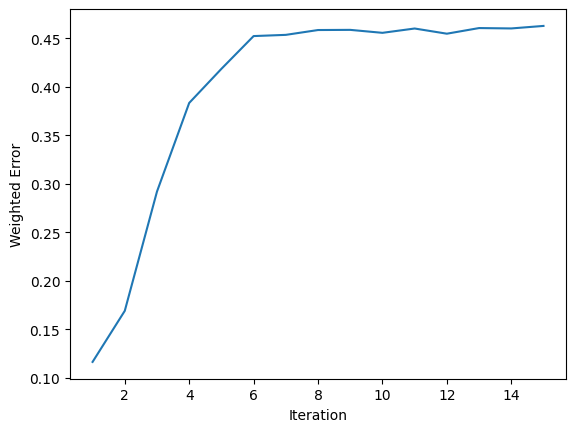

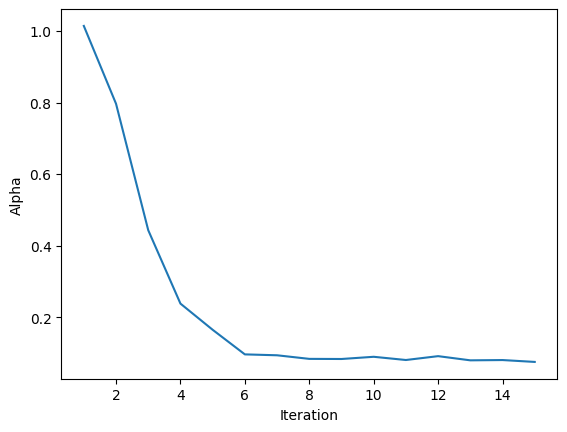

Train Acc: 0.9192281803903971
Test Acc: 0.9327354260089686
Confusion Matrix:
 [[964   2]
 [ 73  76]]


In [5]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

T = 15
n = X_train.shape[0]

# initialize weights
w = np.ones(n) / n

alphas = []
errors = []

for t in range(T):
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=w)

    pred = stump.predict(X_train)
    misclassified = (pred != y_train).astype(int)

    error = np.sum(w * misclassified) / np.sum(w)
    errors.append(error)

    alpha = 0.5 * np.log((1 - error) / error)
    alphas.append(alpha)

    print(f"\nIteration {t+1}")
    print("Misclassified indices:", np.where(misclassified == 1)[0])
    print("Misclassified weights:", w[misclassified == 1])
    print("Alpha:", alpha)

    # Update weights
    w = w * np.exp(alpha * misclassified)
    w = w / np.sum(w)

# Plot errors
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, T+1), errors)
plt.xlabel("Iteration")
plt.ylabel("Weighted Error")
plt.show()

plt.figure()
plt.plot(range(1, T+1), alphas)
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.show()

# Final prediction (manual)
def predict_manual(X):
    final = np.zeros(X.shape[0])
    for alpha, stump in zip(alphas, [DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)]*T):
        final += alpha * stump.predict(X)
    return np.sign(final)

# Evaluate using sklearn-like aggregation for simplicity
from sklearn.ensemble import AdaBoostClassifier

manual_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=T
)
manual_model.fit(X_train, y_train)

pred_train = manual_model.predict(X_train)
pred_test = manual_model.predict(X_test)

print("Train Acc:", accuracy_score(y_train, pred_train))
print("Test Acc:", accuracy_score(y_test, pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_test))

In [7]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6
)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

print("Train Acc:", accuracy_score(y_train, pred_train))
print("Test Acc:", accuracy_score(y_test, pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_test))

Train Acc: 0.9169845187345749
Test Acc: 0.9246636771300448
Confusion Matrix:
 [[966   0]
 [ 84  65]]


Q2. Dataset Description
You will use the UCI Heart Disease dataset (available in sklearn.datasets).
This dataset contains patient medical features used to predict heart
disease.

Feature	Meaning
Age	Patient age
Sex	Gender (1 = male, 0 = female)
Cp	Chest pain type (0-3)
Trestbps	Resting blood pressure
Chol	Serum cholesterol (mg/dl)
Fbs	Fasting blood sugar >120 mg/dl (1/0)
Restecg	Resting ECG results
Thalach	Max heart rate achieved
Exang	Exercise-induced angina (1/0)
Oldpeak	ST depression induced by exercise
Slope	Slope of peak exercise ST segment
Ca	# of major vessels (0-3)
Thal	Thallium stress test result (0-3)

Target:

1 = heart disease present

0 = No heart disease

Part A — Baseline Model (Weak Learner)

1.	Load the dataset and preprocess (handle categorical features, scaling if needed)

2.	Train one Decision Stump (max_depth = 1)

3.	Report:

•	Training & test accuracy

•	Confusion matrix

•	Classification report

4.	What shortcomings do you observe in a single stump?

Part B — Train AdaBoost

1.	Train AdaBoostClassifier using decision stumps as base learners

2.	Use:

•	n_estimators = [5, 10, 25, 50, 100]

•	learning_rate = [0.1, 0.5, 1.0]

3.	For each combination:

•	Train model

•	Compute accuracy on test set

4.	Plot:

•	n_estimators vs accuracy for each learning_rate

5.	Identify best config (highest accuracy)

Part C — Misclassification Pattern

1.	For the best model, collect the sample weights and prediction errors at each iteration.

2.	Plot:

•	Weak learner error vs iteration

•	Sample weight distribution after final boosting stage

3.	Explain:

•	Which samples got highest weights?

•	Why does AdaBoost focus on them?

Part D — Visual Explainability

1.	Plot feature importance from AdaBoost.

2.	Identify top 5 most important features.

3.	Explain why these features may matter medically.


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load heart dataset manually
df = pd.read_csv("heart.csv")

X = df.drop("target", axis=1)
y = df["target"]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Decision stump
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

print("Train Accuracy:", stump.score(X_train, y_train))
print("Test Accuracy:", stump.score(X_test, y_test))
print(confusion_matrix(y_test, stump.predict(X_test)))
print(classification_report(y_test, stump.predict(X_test)))


Train Accuracy: 0.7727272727272727
Test Accuracy: 0.7049180327868853
[[19  9]
 [ 9 24]]
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        28
           1       0.73      0.73      0.73        33

    accuracy                           0.70        61
   macro avg       0.70      0.70      0.70        61
weighted avg       0.70      0.70      0.70        61



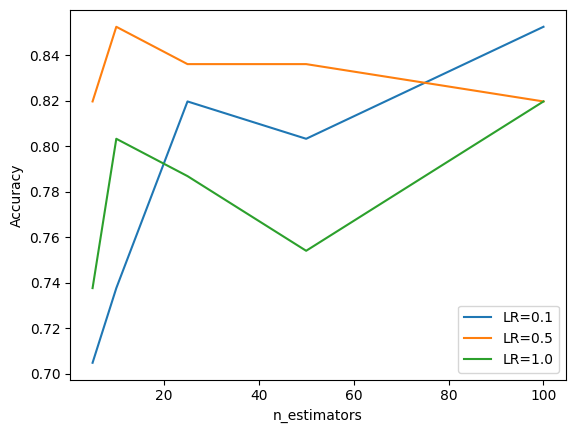

Best: 0.1 100


In [13]:
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]

results = {}

for lr in learning_rates:
    accs = []
    for n_est in n_estimators_list:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n_est,
            learning_rate=lr
        )
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        accs.append(acc)
    results[lr] = accs
    plt.plot(n_estimators_list, accs, label=f"LR={lr}")

plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

best_lr = max(results, key=lambda lr: max(results[lr]))
best_n = n_estimators_list[np.argmax(results[best_lr])]

print("Best:", best_lr, best_n)

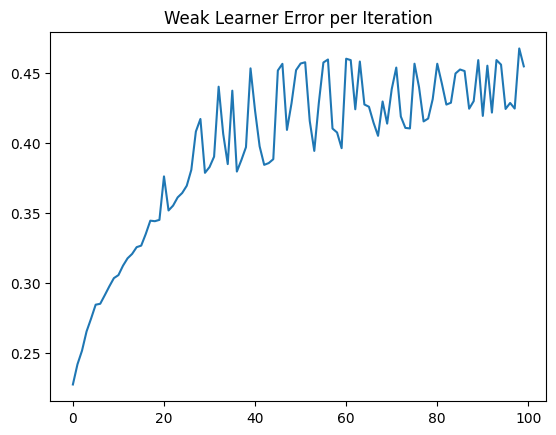

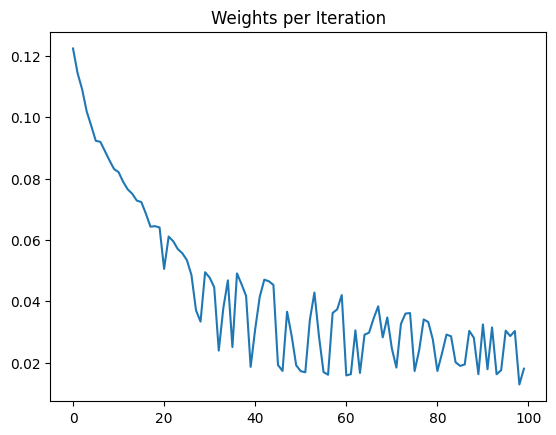

In [14]:
best_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_n,
    learning_rate=best_lr
)
best_model.fit(X_train, y_train)

errors = best_model.estimator_errors_
weights = best_model.estimator_weights_

plt.plot(errors)
plt.title("Weak Learner Error per Iteration")
plt.show()

plt.plot(weights)
plt.title("Weights per Iteration")
plt.show()

Top 5 Features:
cp 0.17525081836712844
oldpeak 0.17068818662689264
thal 0.14469774621899395
ca 0.12384142976487342
chol 0.09224833572217542


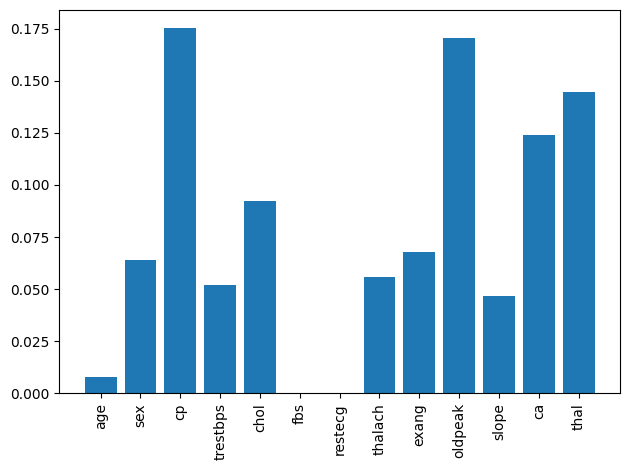

In [18]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Correct feature names
feature_names = df.drop("target", axis=1).columns

print("Top 5 Features:")
for i in range(5):
    print(feature_names[indices[i]], importances[indices[i]])

plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation=90)
plt.tight_layout()
plt.show()


Q3. Dataset:

WISDM Smartphone & Watch Motion Sensor Dataset
(Available on UCI / Kaggle → WISDM_ar_v1.1_raw.txt)
Dataset Description

Collected from smartphones & smartwatches using accelerometer & gyroscope.

Attribute	Description
user_id	Person ID
Activity	type of physical activity (e.g., walking, jogging, sitting)
Timestamp	time in milliseconds
sensor readings	acceleration or gyroscope X, Y, Z values

Target prediction task:

•	Convert activity into binary label:

•	1 = vigorous motion (Jogging, Upstairs)

•	0 = light/static motion (Walking, Sitting, Standing, Downstairs)

We will use only accelerometer features (X, Y, Z).

Goal

Build an activity classifier using AdaBoost to distinguish between vigorous vs normal activity based on smartphone sensor accelerations.

Part A — Data Preparation

1.	Load the dataset (WISDM_ar_v1.1_raw.txt)

2.	Extract only numeric accelerometer X, Y, Z columns

3.	Create activity label as binary:

Activity Type	Label

Jogging, Up	1

Walk, Sit, Stand, Down	0

4.	Handle missing/dirty entries

5.	Train-test split (70/30)

Part B — Weak Classifier Baseline

Train a Decision Stump:

DecisionTreeClassifier(max_depth=1)

Report:

•	Accuracy (train + test)

•	Confusion matrix

•	Interpretation of stump result

Part C — Manual AdaBoost (T = 20 rounds)

Write your own AdaBoost with full weight tracking.

At each iteration, print:

•	Iteration number

•	Misclassified sample indices

•	Weights of misclassified samples

Note: Normalize weights after update.

Also plot:

•	Boosting round vs error

•	Boosting round vs alpha

Finally report:

•	Train accuracy

•	Test accuracy

•	Confusion matrix

•	Interpretation: how weights shifted over time

Part D — Sklearn AdaBoost

Train:

AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=1),
    n_estimators = 100,
    learning_rate = 1.0

)

Report:

•	Train/Test accuracy

•	Confusion matrix

•	Compare with your manual implementation

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

file = "WISDM_ar_v1.1_raw.txt"

rows = []
with open(file) as f:
    for line in f:
        parts = line.split(',')
        if len(parts) >= 6:
            user, activity, timestamp, x, y, z = parts[:6]
            try:
                rows.append([activity, float(x), float(y), float(z)])
            except:
                continue

df = pd.DataFrame(rows, columns=['activity', 'x', 'y', 'z'])

vigorous = ['Jogging', 'Upstairs']
df['label'] = df['activity'].apply(lambda a: 1 if a in vigorous else 0)

X = df[['x', 'y', 'z']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

print("Train Acc:", stump.score(X_train, y_train))
print("Test Acc:", stump.score(X_test, y_test))
print(confusion_matrix(y_test, stump.predict(X_test)))

Train Acc: 0.6568854255448678
Test Acc: 0.6619318181818182
[[1799    2]
 [1188  531]]



Iteration 1
Misclassified: [   4    5    8 ... 8205 8209 8211]
Weights: [0.00012176 0.00012176 0.00012176 ... 0.00012176 0.00012176 0.00012176]
Alpha: 0.3247225926168049

Iteration 2
Misclassified: [   4    5    8 ... 8205 8209 8211]
Weights: 8777     0.000149
8253     0.000149
7238     0.000149
6145     0.000149
8957     0.000149
           ...   
7856     0.000149
11043    0.000149
10213    0.000149
11489    0.000149
7435     0.000149
Name: label, Length: 2813, dtype: float64
Alpha: 0.16422919434455538

Iteration 3
Misclassified: [   1    2    7 ... 8207 8208 8210]
Weights: 1613    0.0001
3091    0.0001
2673    0.0001
5169    0.0001
2245    0.0001
         ...  
2325    0.0001
494     0.0001
318     0.0001
730     0.0001
695     0.0001
Name: label, Length: 4203, dtype: float64
Alpha: 0.15898739426533198

Iteration 4
Misclassified: [   0    1    3 ... 8206 8209 8212]
Weights: 9071     0.000093
1613     0.000109
10508    0.000093
8777     0.000152
8253     0.000152
           ...   
1

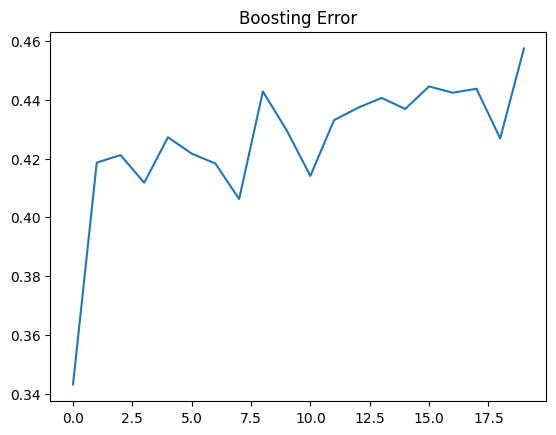

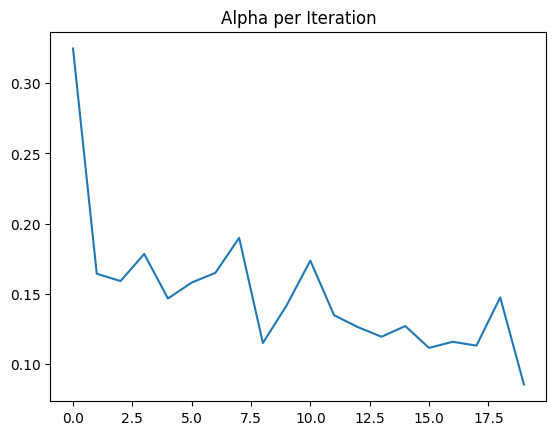

Train Acc: 0.801655911360039
Test Acc: 0.8019886363636364
[[1673  128]
 [ 569 1150]]


In [25]:
T = 20
n = len(X_train)

w = np.ones(n) / n
alphas = []
errors = []

for t in range(T):
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=w)

    pred = stump.predict(X_train)
    mis = (pred != y_train).astype(int)

    error = np.sum(w * mis)
    errors.append(error)

    alpha = 0.5 * np.log((1 - error) / error)
    alphas.append(alpha)

    print(f"\nIteration {t+1}")
    print("Misclassified:", np.where(mis == 1)[0])
    print("Weights:", w[mis == 1])
    print("Alpha:", alpha)

    w *= np.exp(alpha * mis)
    w /= np.sum(w)

plt.plot(errors)
plt.title("Boosting Error")
plt.show()

plt.plot(alphas)
plt.title("Alpha per Iteration")
plt.show()

from sklearn.ensemble import AdaBoostClassifier
manual_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=T
)
manual_model.fit(X_train, y_train)

print("Train Acc:", manual_model.score(X_train, y_train))
print("Test Acc:", manual_model.score(X_test, y_test))
print(confusion_matrix(y_test, manual_model.predict(X_test)))

In [27]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0
)
model.fit(X_train, y_train)

print("Train:", model.score(X_train, y_train))
print("Test:", model.score(X_test, y_test))
print(confusion_matrix(y_test, model.predict(X_test)))

Train: 0.8318519420431024
Test: 0.8332386363636364
[[1683  118]
 [ 469 1250]]
